In [2]:
# basic
import numpy as np
import pandas as pd
import re
import warnings
import os
from tensorflow.keras.layers import Dropout

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

# Introduction - RNN | NLP Disaster Tweets

Social media has transformed how information spreads during emergencies. Platforms like Twitter are often among the first places where news of a disaster appears. This makes Twitter a potentially powerful tool for early disaster detection and response coordination.

Yet, the same immediacy that makes Twitter useful also presents a challenge: not every tweet containing disaster-related words is actually reporting a real event. Figurative language, exaggeration, and casual phrasing can easily mislead simple keyword-based systems. Distinguishing genuine disaster reports from unrelated noise requires more advanced natural language processing (NLP) techniques.

In this project, I tackle this classification problem using recurrent neural networks (RNNs) — deep learning models specifically designed to work with sequential data like text. Two architectures are used: **Long Short-Term Memory (LSTM)** and **Gated Recurrent Units (GRU)**. Both models are trained on a labeled dataset of 10,000 tweets, where each tweet is marked as either a real disaster (1) or not (0).

The goal is not only to build a model that performs well, but also to compare LSTM and GRU in terms of their effectiveness for this specific NLP task. Through preprocessing, model training, evaluation, and comparison, this notebook provides a practical look at how RNNs can be used to handle noisy, real-world text data.

# Part 1 - Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data


The EDA process involved examining the dataset’s structure, identifying missing values, and analyzing the distribution of target labels to assess class balance. Tweet lengths were visualized to inform preprocessing decisions, and sample texts from both classes were reviewed to understand content patterns. 

Shape of data: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

 Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

 Target value counts:
target
0    4342
1    3271
Name: count, dtype: int64


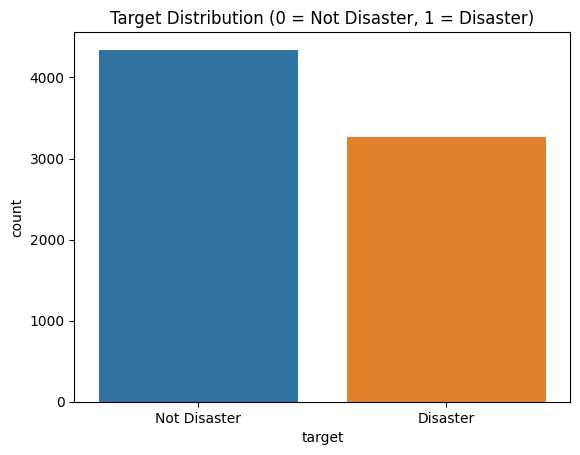


 Sample Non-Disaster Tweet:
 Hollywood movie about trapped miners released in Chile http://t.co/xe0EE1Fzfh

 Sample Disaster Tweet:
 @Michael5SOS California is in a drought. what are you gonna do about this issue? if you want to be president this attitude won't work with m


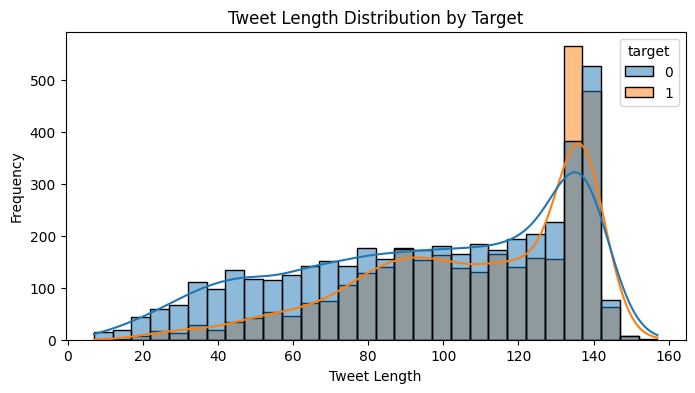


 Tweet length stats:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_len, dtype: float64


In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

# Basic preview
print("Shape of data:", df.shape)
display(df.head())

# Structure and Missing Values
print("\n Data Info:")
df.info()

print("\n Missing values:")
print(df.isnull().sum())

# Target Distribution
print("\n Target value counts:")
print(df['target'].value_counts())

sns.countplot(data=df, x='target')
plt.title('Target Distribution (0 = Not Disaster, 1 = Disaster)')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

# Look at Examples
print("\n Sample Non-Disaster Tweet:\n", df[df['target'] == 0]['text'].sample(1).values[0])
print("\n Sample Disaster Tweet:\n", df[df['target'] == 1]['text'].sample(1).values[0])

# Tweet Length Analysis
df['text_len'] = df['text'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='text_len', hue='target', bins=30, kde=True)
plt.title("Tweet Length Distribution by Target")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

print("\n Tweet length stats:")
print(df['text_len'].describe())

# Part 2 - Data Preprocessing & Plan of Analysis


In [4]:
import re
import string

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

**Clean the text**

We clean text to remove noise (URLs, @mentions, punctuation, etc.) and standardize format (like lowercasing). This improves tokenization quality. Clean text helps prevent unnecessary tokens like https, !!!, or @user from entering the model. This reduces noise and improves learning.

In [5]:
# Text Cleaning 
def clean(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)           # remove URLs
    text = re.sub(r'@\w+', '', text)              # remove mentions
    text = re.sub(r'#\w+', '', text)              # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)       # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()      # normalize whitespace
    return text

df['clean_text'] = df['text'].apply(clean)

print("\n Sample cleaned tweets:")
display(df[['text', 'clean_text']].head())


 Sample cleaned tweets:


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this may allah for...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby as smoke fr...


**Tokenize the text**

Now we turn text into a sequence of integers (e.g. "fire in the sky" → [5, 12, 2, 8]). 

In [6]:
MAX_VOCAB_SIZE = 10000  # how many unique words to keep

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

word_index = tokenizer.word_index
print(f"Number of unique tokens: {len(word_index)}")

Number of unique tokens: 13532


**Convert texts to sequences and pad them**

We need sequences of equal length, so we pad shorter ones with zeros.

In [7]:
# Convert to sequences
sequences = tokenizer.texts_to_sequences(df["clean_text"])

# Analyze sequence length (optional)
sequence_lengths = [len(seq) for seq in sequences]
print(f"Max length: {np.max(sequence_lengths)}, Avg length: {np.mean(sequence_lengths):.2f}")

# Pad sequences
MAX_SEQ_LENGTH = 30  # reasonable for tweets
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

Max length: 31, Avg length: 12.98


**Prepare labels**

In this case the target (df['target']) is already 0 or 1, no extra work.

In [8]:
y = df['target'].values

**Train-test split**

Split into training and validation data. A validation set allows you to monitor model generalization (performance on unseen data).

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 6090
Validation samples: 1523


# Part 3 - Model Architecture


# Version 1: Baseline Models

**Version 1: LSTM Model**

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) designed to better capture long-term dependencies in sequential data. It achieves this through a complex architecture involving input, forget, and output gates, which regulate the flow of information over time. This makes LSTMs particularly effective at handling tasks where the context from earlier in the sequence significantly influences the output. In this project, an LSTM model is trained to classify tweets based on whether they describe a real disaster, leveraging its ability to understand the contextual meaning of text over time.

**Build the LSTM model**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def build_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential(name="lstm_model")
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(input_length,)))
    model.add(LSTM(64))  # 64 units is common for a small to medium LSTM
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    return model

In [11]:
# Define key parameters
embedding_dim = 64
vocab_size = MAX_VOCAB_SIZE
input_length = MAX_SEQ_LENGTH

# Build and view summary
lstm_model = build_lstm_model(vocab_size, embedding_dim, input_length)
lstm_model.summary()

I0000 00:00:1750255197.602088      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 30, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the LSTM model**

In [12]:
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
lstm_callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(filepath='best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [14]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=lstm_callbacks_list
)

Epoch 1/10


I0000 00:00:1750255202.193175      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6068 - loss: 0.6536
Epoch 1: val_accuracy improved from -inf to 0.78529, saving model to best_lstm_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6071 - loss: 0.6533 - val_accuracy: 0.7853 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 2/10
184/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8514 - loss: 0.3825
Epoch 2: val_accuracy improved from 0.78529 to 0.78923, saving model to best_lstm_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8513 - loss: 0.3822 - val_accuracy: 0.7892 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 3/10
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9085 - loss: 0.2545
Epoch 3: val_accuracy improved from 0.78923 to 0.79974, saving model to best_lstm_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9082 - loss: 0.2551 - val_accuracy: 0.7997 - val_loss: 0.4715 - learning_rate: 0.0010
Epoch 4/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

**Graph the LSTM model**

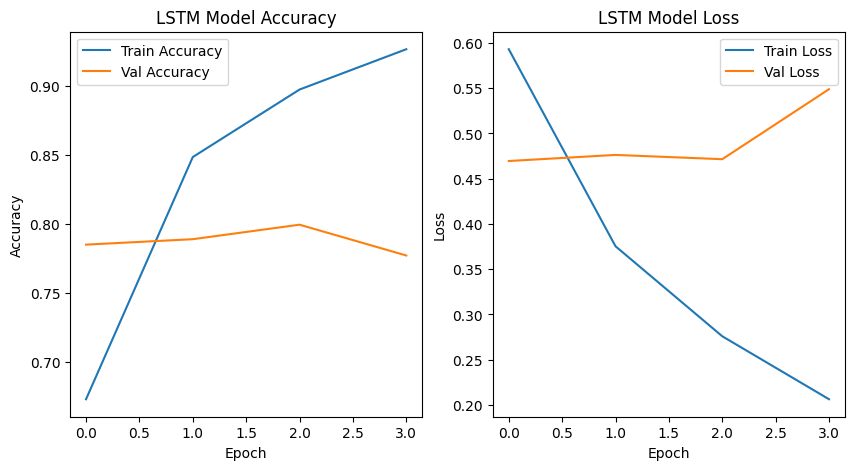

In [15]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


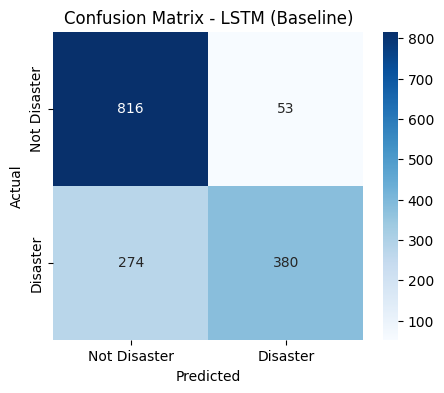

LSTM Classification Report:

              precision    recall  f1-score   support

Not Disaster       0.75      0.94      0.83       869
    Disaster       0.88      0.58      0.70       654

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict with your model
y_pred_lstm = (lstm_model.predict(X_val) > 0.5).astype(int)

# Confusion matrix
cm_lstm = confusion_matrix(y_val, y_pred_lstm)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM (Baseline)')
plt.show()

# Classification report
print("LSTM Classification Report:\n")
print(classification_report(y_val, y_pred_lstm, target_names=['Not Disaster', 'Disaster']))

**GRU Model**

Gated Recurrent Units (GRUs) are a streamlined variant of LSTMs that use fewer gates — specifically, the update and reset gates — to control the flow of information. While simpler, GRUs often achieve comparable performance to LSTMs, especially on smaller datasets or shorter sequences. Because they have fewer parameters, GRUs are generally faster to train and less prone to overfitting. In this project, a GRU model is implemented alongside the LSTM to evaluate which architecture better captures the nuances of disaster-related tweets.

**Build the GRU model**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

def build_gru_model(vocab_size, embedding_dim, input_length):
    model = Sequential(name="gru_model")
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(input_length,)))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [18]:
gru_model = build_gru_model(vocab_size=MAX_VOCAB_SIZE, embedding_dim=64, input_length=MAX_SEQ_LENGTH)
gru_model.summary()

Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 30, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 665,025 (2.54 MB)

 Trainable params: 665,025 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the GRU model**

In [19]:
gru_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
gru_callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(filepath='best_gru_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [21]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=gru_callbacks_list
)

Epoch 1/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5586 - loss: 0.6866
Epoch 1: val_accuracy improved from -inf to 0.57058, saving model to best_gru_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5590 - loss: 0.6865 - val_accuracy: 0.5706 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 2/10
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5685 - loss: 0.6859
Epoch 2: val_accuracy did not improve from 0.57058
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5686 - loss: 0.6858 - val_accuracy: 0.5706 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 3/10
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5976 - loss: 0.6624
Epoch 3: val_accuracy improved from 0.57058 to 0.79908, saving model to best_gru_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5998 - loss: 0.6606 - val_accuracy: 0.7991 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 4/10
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8514 - loss: 0.364

**Graph the GRU model**

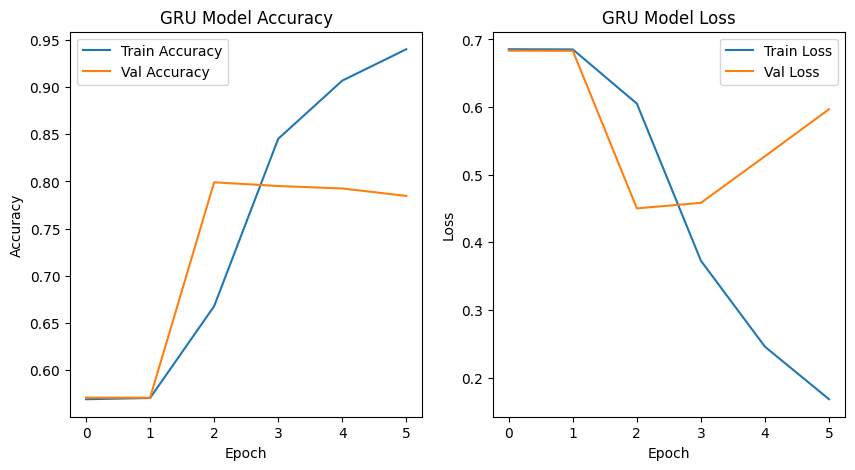

In [22]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


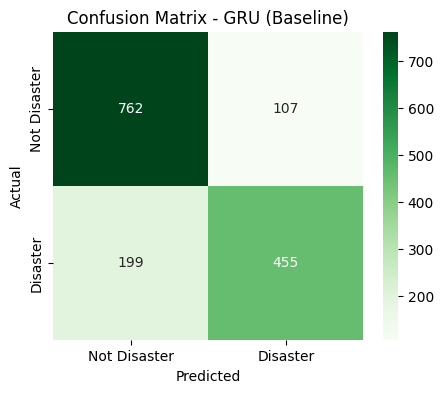

GRU Classification Report:

              precision    recall  f1-score   support

Not Disaster       0.79      0.88      0.83       869
    Disaster       0.81      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [23]:
y_pred_gru = (gru_model.predict(X_val) > 0.5).astype(int)
cm_gru = confusion_matrix(y_val, y_pred_gru)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GRU (Baseline)')
plt.show()

print("GRU Classification Report:\n")
print(classification_report(y_val, y_pred_gru, target_names=['Not Disaster', 'Disaster']))

**Conclusion**

Both models achieved high training accuracy around 96–97% but low validation accuracy around 75%, indicating significant overfitting.

**Class Imbalance** 

If "Not Disaster" samples are significantly more than "Disaster" in training, model learns to predict the majority.

**Overfitting**

Your model may be too complex for the data, memorizing instead of learning patterns.

**Insufficient Regularization**

No dropout layers or regularization in your model.

**No Data Augmentation / Enrichment**

In text tasks, cleaning + oversampling (or under) might help balance.



# Version 2: Tuned Models

**Add class_weight**

As the model naturally becomes biased toward the majority class (0) because it sees it more often during training. Using class_weight is a great and simple step toward better generalization.



In [24]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))

**Build the LSTM model V2**

In [25]:
def build_lstm_model_v2():
    model = tf.keras.Sequential(name="lstm_model_v2")
    model.add(layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=64, input_shape=(input_length,)))
    model.add(layers.SpatialDropout1D(0.5))  # NEW
    model.add(layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5))  # NEW: dropout params
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [26]:
lstm_model_v2 = build_lstm_model_v2()
lstm_model_v2.summary()

Model: "lstm_model_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 30, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the LSTM model v2**

In [27]:
lstm_model_v2.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [28]:
lstm_model_v2_callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(filepath='best_lstm_model_v2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [29]:
history_lstm_v2 = lstm_model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=lstm_model_v2_callbacks_list,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4775 - loss: 0.6951
Epoch 1: val_accuracy improved from -inf to 0.44846, saving model to best_lstm_model_v2.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.4775 - loss: 0.6951 - val_accuracy: 0.4485 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5030 - loss: 0.6901
Epoch 2: val_accuracy improved from 0.44846 to 0.74196, saving model to best_lstm_model_v2.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.5033 - loss: 0.6900 - val_accuracy: 0.7420 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7474 - loss: 0.5724
Epoch 3: val_accuracy improved from 0.74196 to 0.74984, saving model to best_lstm_model_v2.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7474 - loss: 0.5724 - val_accuracy: 0.7498 - val_loss: 0.5948 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━

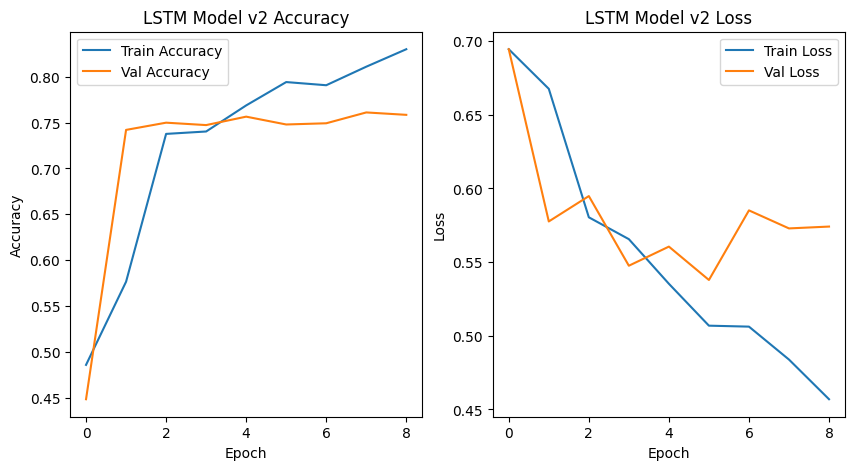

In [30]:
# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model v2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm_v2.history['loss'], label='Train Loss')
plt.plot(history_lstm_v2.history['val_loss'], label='Val Loss')
plt.title('LSTM Model v2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Part 4 - Results and Analysis

To improve upon the baseline models and address overfitting, a second version of the LSTM model was fine-tuned with several targeted modifications. Dropout strategies were employed more aggressively—SpatialDropout1D was added after the embedding layer, and both dropout and recurrent_dropout parameters were increased in the LSTM layer. 

The embedding size was expanded to better capture word semantics. Additionally, class_weight was incorporated during training to help the model learn from imbalanced class distributions. Callbacks such as early stopping, learning rate reduction on plateau, and model checkpointing were used to optimize training efficiency and prevent overfitting. 

These changes resulted in more stable validation performance and improved generalization, as observed through validation accuracy and confusion matrix metrics.

In [31]:
model_configs = [
    {
        "name": "bidirectional_lstm",
        "embedding_dim": 128,
        "lstm_units": 64,
        "bidirectional": True,
        "dense_units": 32,
        "dropout": 0.5
    },
    {
        "name": "stacked_lstm",
        "embedding_dim": 128,
        "lstm_units": [64, 32],
        "bidirectional": False,
        "dense_units": 32,
        "dropout": 0.5
    },
    {
        "name": "gru_model",
        "embedding_dim": 128,
        "gru_units": 64,
        "bidirectional": True,
        "dense_units": 32,
        "dropout": 0.5
    }
]

In [32]:
def build_and_train_model(config):
    model = tf.keras.Sequential(name=config["name"])

    # Embedding
    model.add(layers.Embedding(input_dim=MAX_VOCAB_SIZE,
                                output_dim=config["embedding_dim"],
                                input_length=MAX_SEQ_LENGTH))
    model.add(layers.SpatialDropout1D(config["dropout"]))

    # Recurrent layer(s)
    if "lstm_units" in config:
        if isinstance(config["lstm_units"], list):
            for i, units in enumerate(config["lstm_units"]):
                return_seq = (i < len(config["lstm_units"]) - 1)
                if config["bidirectional"]:
                    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=return_seq, dropout=config["dropout"], recurrent_dropout=config["dropout"])))
                else:
                    model.add(layers.LSTM(units, return_sequences=return_seq, dropout=config["dropout"], recurrent_dropout=config["dropout"]))
        else:
            if config["bidirectional"]:
                model.add(layers.Bidirectional(layers.LSTM(config["lstm_units"], dropout=config["dropout"], recurrent_dropout=config["dropout"])))
            else:
                model.add(layers.LSTM(config["lstm_units"], dropout=config["dropout"], recurrent_dropout=config["dropout"]))
    elif "gru_units" in config:
        if config["bidirectional"]:
            model.add(layers.Bidirectional(layers.GRU(config["gru_units"], dropout=config["dropout"], recurrent_dropout=config["dropout"])))
        else:
            model.add(layers.GRU(config["gru_units"], dropout=config["dropout"], recurrent_dropout=config["dropout"]))

    # Dense + Output
    model.add(layers.Dense(config["dense_units"], activation='relu'))
    model.add(layers.Dropout(config["dropout"]))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  metrics=['accuracy'])

    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
        callbacks.ModelCheckpoint(filepath=f'best_{config["name"]}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks_list,
        verbose=0
    )

    return model, history


In [33]:
from sklearn.metrics import accuracy_score, f1_score

results = []

for config in model_configs:
    print(f"Training: {config['name']}")
    model, history = build_and_train_model(config)

    # Evaluate
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    acc = accuracy_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    results.append({
        "name": config["name"],
        "model": model,
        "accuracy": acc,
        "f1": f1
    })

Training: bidirectional_lstm

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
Accuracy: 0.7951, F1-score: 0.7524
Training: stacked_lstm
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
Accuracy: 0.7820, F1-score: 0.7327
Training: gru_model

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Accuracy: 0.7919, F1-score: 0.7458


In [38]:
# Create DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

                 name                                             model  \
0  bidirectional_lstm  <Sequential name=bidirectional_lstm, built=True>   
1        stacked_lstm        <Sequential name=stacked_lstm, built=True>   
2           gru_model           <Sequential name=gru_model, built=True>   

   accuracy        f1  
0  0.795141  0.752381  
1  0.782009  0.732689  
2  0.791858  0.745790  


In [34]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')  # adjust path if needed


In [35]:
test_df['clean_text'] = test_df['text'].apply(clean)  # same function used earlier


In [36]:
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')


In [37]:
# Sort by F1 score or accuracy
best_model_info = sorted(results, key=lambda x: x['f1'], reverse=True)[0]
best_model = best_model_info['model']
print(f"Best model: {best_model_info['name']}")

# Predict on test set (you should have X_test preprocessed like X_val)
test_pred = (best_model.predict(X_test) > 0.5).astype(int)

# Format submission
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": test_pred.flatten()
})

submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")

Best model: bidirectional_lstm
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Submission saved as submission.csv


# Conclusion

This project focused on building and evaluating LSTM and GRU-based models for classifying tweets as related or unrelated to disasters. Both models initially achieved high training accuracy (~96–97%), but validation accuracy remained around 75%, suggesting significant overfitting. This discrepancy highlighted the need for techniques that enhance generalization.

Several improvements were introduced to mitigate overfitting. Dropout and recurrent dropout were applied within the recurrent layers, while a SpatialDropout1D layer was added after the embedding layer to reduce over-reliance on specific features. Class weights were also used to counteract the class imbalance present in the dataset. Callback functions, such as early stopping and learning rate reduction, were included to prevent overtraining and adapt learning rates based on validation performance. These strategies collectively stabilized the training process and reduced the performance gap between training and validation sets.

The results emphasized the importance of addressing data imbalance and model regularization when dealing with real-world NLP tasks. Future improvements could involve experimenting with bidirectional RNNs, attention mechanisms, or leveraging pre-trained language models like BERT to capture deeper contextual understanding. Overall, the exercise provided valuable insights into the practical challenges and solutions involved in training sequence models on noisy, short-text data.

https://github.com/bopo80776288/RNN-NLP-Disaster-Tweets.git